In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
#Load Dataset
df = pd.read_csv("../data/processed/cleaned_data.csv")
print("dataset shape: ", df.shape)

dataset shape:  (5000, 30)


In [3]:
#Feature Engineering
df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]

df["comorbidity_score"] = (
    df["diabetes"] +
    df["hypertension"] +
    df["heart_disease"]
)

df["metabolic_risk"] = df["bmi"] * df["blood_glucose"]

In [ ]:
#Target and Features
y = df["length_of_stay"]

X = df.drop(columns=[
    "risk_category",
    "risk_label",
    "length_of_stay",
    "patient_feedback"
])

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
#preprocessing block
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ]), numeric_features),

        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [8]:
# =====================
# Baseline Model
# =====================

baseline_pred = np.full_like(y_test, y_train.mean())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Results")
print("MAE:", round(baseline_mae,4))
print("RMSE:", round(baseline_rmse,4))
print("R2:", round(baseline_r2,4))

Baseline Results
MAE: 2.1508
RMSE: 2.7555
R2: -0.0025


In [11]:
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print("\nLinear Regression")
print("MAE:", round(lr_mae,4))
print("RMSE:", round(lr_rmse,4))
print("R2:", round(lr_r2,4))


Linear Regression
MAE: 1.5095
RMSE: 2.0514
R2: 0.4443


In [16]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print("MAE:", round(rf_mae,4))
print("RMSE:", round(rf_rmse,4))
print("R2:", round(rf_r2,4))

Random Forest Results
MAE: 1.5547
RMSE: 2.1044
R2: 0.4153


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Results")
print("MAE:", round(xgb_mae,4))
print("RMSE:", round(xgb_rmse,4))
print("R2:", round(xgb_r2,4))

XGBoost Results
MAE: 1.5855
RMSE: 2.1295
R2: 0.4012


In [19]:
results = pd.DataFrame({
    "Model": ["Baseline", "Linear Regression", "Random Forest", "XGBoost"],
    "MAE": [baseline_mae, lr_mae, rf_mae, xgb_mae],
    "RMSE": [baseline_rmse, lr_rmse, rf_rmse, xgb_rmse],
    "R2": [baseline_r2, lr_r2, rf_r2, xgb_r2]
}).round(4)

results

,Model,MAE,RMSE,R2
0,Baseline,2.1508,2.7555,-0.0025
1,Linear Regression,1.5095,2.0514,0.4443
2,Random Forest,1.5547,2.1044,0.4153
3,XGBoost,1.5855,2.1295,0.4012


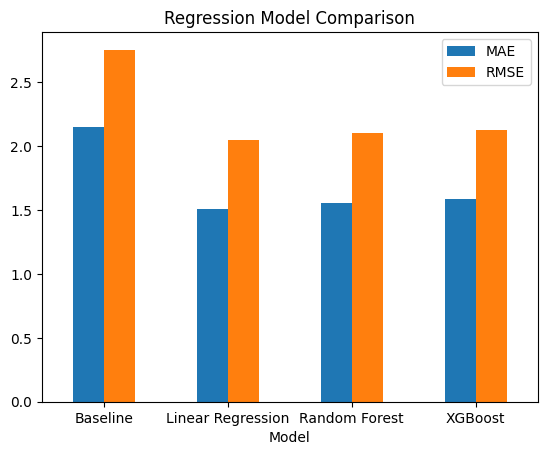

In [22]:
results.set_index("Model")[["MAE","RMSE"]].plot(kind="bar")
plt.title("Regression Model Comparison")
plt.xticks(rotation=0)
plt.show()

In [23]:
# Save the best model (Linear Regression Pipeline)
joblib.dump(lr_pipeline, "../models/los_linear_regression.pkl")

print("Model saved successfully.")

Model saved successfully.
